<a href="https://colab.research.google.com/github/sayakpaul/Knowledge-Distillation-in-Keras/blob/master/Effect_of_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import tensorflow as tf
tf.random.set_seed(666)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


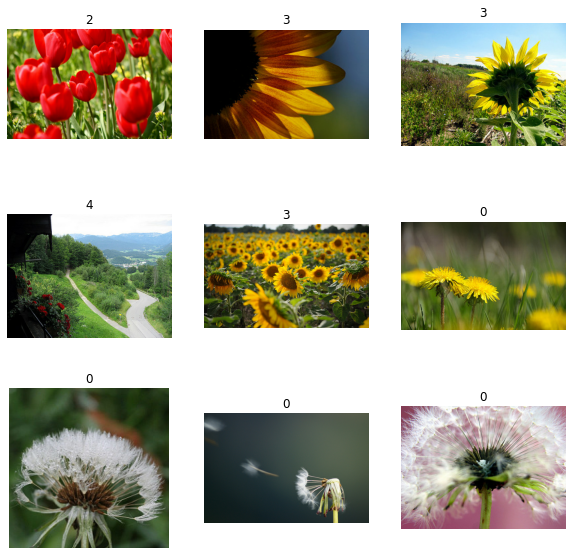

In [ ]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
# Image utils
SIZE = (224, 224)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, SIZE)
    return (image, label)

training_loader = (
    train_ds
    .shuffle(1024)
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_loader = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
# A bit of augmentation
@tf.function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize_with_crop_or_pad(image, SIZE[0] + 6, SIZE[1] + 6) 
    image = tf.image.random_crop(image, size=[SIZE[0], SIZE[1], 3])
    return image, label

# Prepare augmented loaders
training_aug_loader = (
    train_ds
    .shuffle(1024)
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .cache()
    .map(augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
# Teacher model utility
base_model = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
base_model.trainable = True

def get_teacher_model():
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(5)(x)
    classifier = models.Model(inputs=inputs, outputs=x)
    
    return classifier

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
get_teacher_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
# Define loss function and optimizer
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # Low since we are fine-tuning

First train the teacher model ***without any augmentation***. 

In [ ]:
# Train the teacher model
teacher_model = get_teacher_model()
teacher_model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
teacher_model.fit(training_loader,
                  validation_data=validation_loader,
                  epochs=5)

Epoch 1/5
      2/Unknown - 1s 257ms/step - loss: 1.9634 - accuracy: 0.1328WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1814s vs `on_train_batch_end` time: 0.3320s). Check your callbacks.


49/49 [==============================] - 24s 493ms/step - loss: 1.1505 - accuracy: 0.5612 - val_loss: 0.6479 - val_accuracy: 0.7873
Epoch 2/5
49/49 [==============================] - 22s 455ms/step - loss: 0.5255 - accuracy: 0.8141 - val_loss: 0.4306 - val_accuracy: 0.8564
Epoch 3/5
49/49 [==============================] - 23s 465ms/step - loss: 0.3561 - accuracy: 0.8788 - val_loss: 0.3604 - val_accuracy: 0.8782
Epoch 4/5
49/49 [==============================] - 23s 463ms/step - loss: 0.2668 - accuracy: 0.9144 - val_loss: 0.3252 - val_accuracy: 0.8964
Epoch 5/5
49/49 [==============================] - 23s 466ms/step - loss: 0.2080 - accuracy: 0.9388 - val_loss: 0.3067 - val_accuracy: 0.8982


In [ ]:
# Evaluate and serialize
print("Test accuracy: {:.2f}".format(teacher_model.evaluate(validation_loader)[1]*100))
teacher_model.save_weights("teacher_model.h5")

9/9 [==============================] - 1s 68ms/step - loss: 0.3067 - accuracy: 0.8982
Test accuracy: 89.82


In [ ]:
# Student model utility
def get_student_model(deeper=False):
    student_model = models.Sequential()
    student_model.add(layers.Conv2D(64, (3, 3), 
        input_shape=(224, 224, 3), 
        activation="relu",
        kernel_initializer="he_normal"))
    student_model.add(layers.MaxPooling2D((4, 4)))
    
    student_model.add(layers.Conv2D(128, (3, 3), 
        activation="relu",
        kernel_initializer="he_normal"))
    
    if deeper:
        student_model.add(tf.keras.layers.MaxPooling2D((4, 4)))
        student_model.add(tf.keras.layers.Conv2D(256, (3, 3), 
            activation="relu",
            kernel_initializer="he_normal"))
    
    student_model.add(layers.GlobalAveragePooling2D())
    student_model.add(layers.Dense(512, activation='relu'))
    student_model.add(layers.Dense(5))

    return student_model

In [ ]:
get_student_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 144,261
Trainable params: 144,261
Non-trainable params: 0
__________________________________________________

In [ ]:
# Average the loss across the batch size within an epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")

# Specify the performance metric
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="valid_acc")

In [ ]:
# Define the training loop

def get_kd_loss(student_logits, teacher_logits, 
                true_labels, temperature,
                alpha, beta):
    teacher_probs = tf.nn.softmax(teacher_logits / temperature)
    kd_loss = tf.keras.losses.categorical_crossentropy(
        teacher_probs, student_logits / temperature, 
        from_logits=True)
    
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(
        true_labels, student_logits, from_logits=True)
    
    total_loss = (alpha * kd_loss) + (beta * ce_loss)
    return total_loss / (alpha + beta)

class Student(tf.keras.Model):
    def __init__(self, trained_teacher, student, 
                 temperature=5., alpha=0.9, beta=0.1):
        super(Student, self).__init__()
        self.trained_teacher = trained_teacher
        self.student = student
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta

    def train_step(self, data):
        images, labels = data
        teacher_logits = self.trained_teacher(images)
        
        with tf.GradientTape() as tape:
            student_logits = self.student(images)
            loss = get_kd_loss(student_logits, teacher_logits,  
                               labels, self.temperature,
                               self.alpha, self.beta)
        gradients = tape.gradient(loss, self.student.trainable_variables)
        # As mentioned in Section 2 of https://arxiv.org/abs/1503.02531
        gradients = [gradient * (self.temperature ** 2) for gradient in gradients]
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        train_loss.update_state(loss)
        train_acc.update_state(labels, tf.nn.softmax(student_logits))
        t_loss, t_acc = train_loss.result(), train_acc.result()
        train_loss.reset_states(), train_acc.reset_states()
        return {"train_loss": t_loss, "train_accuracy": t_acc}

    def test_step(self, data):
        images, labels = data
        teacher_logits = self.trained_teacher(images)
        
        student_logits = self.student(images, training=False)
        loss = get_kd_loss(student_logits, teacher_logits,  
                               labels, self.temperature,
                               self.alpha, self.beta)
        
        valid_loss.update_state(loss)
        valid_acc.update_state(labels, tf.nn.softmax(student_logits))
        v_loss, v_acc = valid_loss.result(), valid_acc.result()
        valid_loss.reset_states(), valid_acc.reset_states()
        return {"loss": v_loss, "accuracy": v_acc}

**Shallower model with higher temperature**

In [ ]:
student = Student(teacher_model, get_student_model())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
student.compile(optimizer)

student.fit(training_aug_loader, # Use augmentation here
            validation_data=validation_loader,
            epochs=10)

Epoch 1/10
49/49 [==============================] - 9s 189ms/step - train_loss: 1.5595 - train_accuracy: 0.3976 - val_loss: 1.5079 - val_accuracy: 0.5263
Epoch 2/10
49/49 [==============================] - 7s 153ms/step - train_loss: 1.4968 - train_accuracy: 0.5382 - val_loss: 1.4778 - val_accuracy: 0.5789
Epoch 3/10
49/49 [==============================] - 8s 154ms/step - train_loss: 1.4775 - train_accuracy: 0.5825 - val_loss: 1.4971 - val_accuracy: 0.6316
Epoch 4/10
49/49 [==============================] - 8s 154ms/step - train_loss: 1.4632 - train_accuracy: 0.6183 - val_loss: 1.4400 - val_accuracy: 0.7105
Epoch 5/10
49/49 [==============================] - 8s 154ms/step - train_loss: 1.4460 - train_accuracy: 0.6433 - val_loss: 1.4178 - val_accuracy: 0.7368
Epoch 6/10
49/49 [==============================] - 8s 155ms/step - train_loss: 1.4374 - train_accuracy: 0.6635 - val_loss: 1.4082 - val_accuracy: 0.7632
Epoch 7/10
49/49 [==============================] - 8s 154ms/step - train_lo

This suggests longer training would have helped. 

In [ ]:
# Serialize
student.student.save_weights("student_model.h5")

In [ ]:
# Investigate the sizes
!ls -lh *.h5

-rw-r--r-- 1 root root 583K Sep  4 05:19 student_model.h5
-rw-r--r-- 1 root root 8.9M Sep  4 05:16 teacher_model.h5


**Trying a deeper model**

In [ ]:
student = Student(teacher_model, get_student_model(deeper=True))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
student.compile(optimizer)

student.fit(training_aug_loader, # Use augmentation here
            validation_data=validation_loader,
            epochs=10)

Epoch 1/10
49/49 [==============================] - 8s 172ms/step - train_loss: 1.7944 - train_accuracy: 0.3582 - val_loss: 1.4969 - val_accuracy: 0.5526
Epoch 2/10
49/49 [==============================] - 8s 155ms/step - train_loss: 1.4983 - train_accuracy: 0.5119 - val_loss: 1.4800 - val_accuracy: 0.6053
Epoch 3/10
49/49 [==============================] - 8s 157ms/step - train_loss: 1.4762 - train_accuracy: 0.5793 - val_loss: 1.4490 - val_accuracy: 0.6842
Epoch 4/10
49/49 [==============================] - 8s 156ms/step - train_loss: 1.4573 - train_accuracy: 0.6170 - val_loss: 1.4271 - val_accuracy: 0.7368
Epoch 5/10
49/49 [==============================] - 8s 157ms/step - train_loss: 1.4468 - train_accuracy: 0.6345 - val_loss: 1.4408 - val_accuracy: 0.7368
Epoch 6/10
49/49 [==============================] - 8s 156ms/step - train_loss: 1.4386 - train_accuracy: 0.6594 - val_loss: 1.4177 - val_accuracy: 0.7105
Epoch 7/10
49/49 [==============================] - 8s 158ms/step - train_lo